In [4]:
import os
from ultralytics import YOLO

# On remonte d'un dossier (..) puis on entre dans 'models'
model_path = os.path.join("..", "models", "best1.pt")

if os.path.exists(model_path):
    model = YOLO(model_path)
    print(" Succès ! Le modèle est chargé.")
else:
    print(f" Toujours introuvable à : {os.path.abspath(model_path)}")
    print("Vérifiez que le dossier 'models' est bien dans 'SmartALPR_Project' et non dans 'modules'.")

 Succès ! Le modèle est chargé.


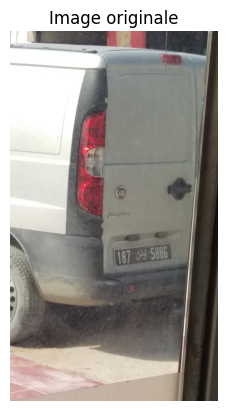


image 1/1 D:\Downloads\SmartALPR_Project\merged_dataset\test\images\2.jpg: 640x384 1 license_plate, 56.2ms
Speed: 4.7ms preprocess, 56.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)
✅ 1 plaque(s) détectée(s)


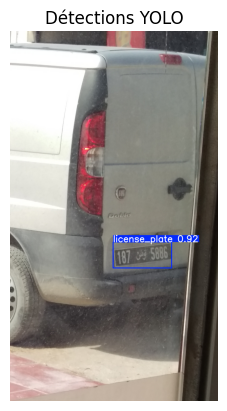

 Cropped plate saved at: runs/detect/mp\first_plate.png


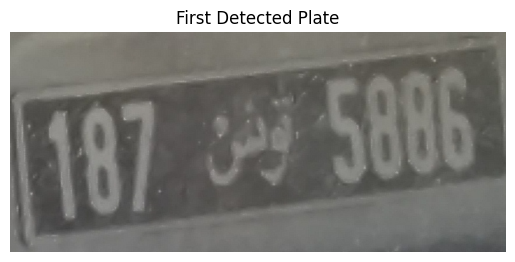

In [6]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os





img_path = r"D:\Downloads\SmartALPR_Project\merged_dataset\test\images\2.jpg"

if not os.path.exists(img_path):
    raise FileNotFoundError(f" L'image {img_path} n'existe pas !")

output_dir = "runs/detect/mp"
os.makedirs(output_dir, exist_ok=True)
img = cv2.imread(img_path)
if img is None:
    raise ValueError(" Impossible de charger l'image")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title("Image originale")
plt.axis("off")
plt.show()


results = model.predict(
    source=img_path,
    imgsz=640,      
    conf=0.25,      
    device="cpu"
)


if len(results[0].boxes) == 0:
    print("❌ Aucune plaque détectée")
else:
    print(f"✅ {len(results[0].boxes)} plaque(s) détectée(s)")


    annotated_img = results[0].plot()
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.title("Détections YOLO")
    plt.axis("off")
    plt.show()


    first_box = results[0].boxes.xyxy[0].cpu().numpy()  # first detection
    x1, y1, x2, y2 = map(int, first_box)

    h, w = img.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    crop = img[y1:y2, x1:x2]

    crop_path = os.path.join(output_dir, "first_plate.png")
    cv2.imwrite(crop_path, crop)
    print(f" Cropped plate saved at: {crop_path}")

    plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    plt.title("First Detected Plate")
    plt.axis("off")
    plt.show()


In [7]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.9200])
data: tensor([[1.4987e+03, 3.0656e+03, 2.3491e+03, 3.4421e+03, 9.2005e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (5376, 3024)
shape: torch.Size([1, 6])
xywh: tensor([[1923.8987, 3253.8516,  850.3412,  376.4731]])
xywhn: tensor([[0.6362, 0.6053, 0.2812, 0.0700]])
xyxy: tensor([[1498.7281, 3065.6150, 2349.0693, 3442.0881]])
xyxyn: tensor([[0.4956, 0.5702, 0.7768, 0.6403]])

In [8]:
first_box

array([     1498.7,      3065.6,      2349.1,      3442.1], dtype=float32)

In [9]:
x1, y1, x2, y2 = map(int, first_box)
x1, y1, x2, y2

(1498, 3065, 2349, 3442)

In [11]:
import easyocr
import cv2
import re


gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
reader = easyocr.Reader(['ar', 'en'], gpu=True)

result = reader.readtext(gray, detail=0)
print("Corrected OCR text:", result)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
c:\Users\HP GAMING\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Corrected OCR text: ['107', 'من', '5٥']


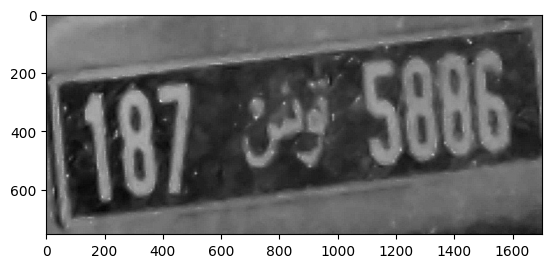

In [12]:

gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
plt.imshow(gray, cmap='gray')


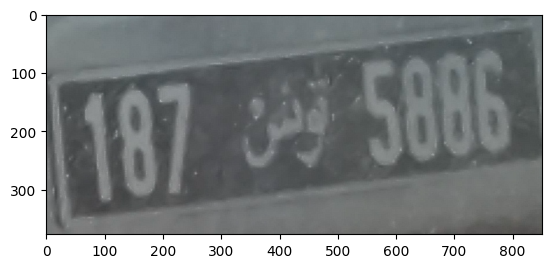

In [13]:
plt.imshow(crop, cmap='gray')

(-0.5, 850.5, 376.5, -0.5)

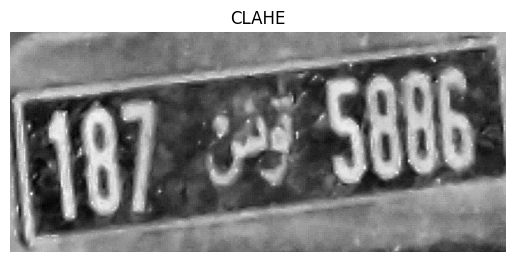

In [ ]:
import cv2
import matplotlib.pyplot as plt

gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)

# Amélioration locale du contraste
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
gray_clahe = clahe.apply(gray)

plt.imshow(gray_clahe, cmap='gray')
plt.title("CLAHE")
plt.axis('off')


(-0.5, 850.5, 376.5, -0.5)

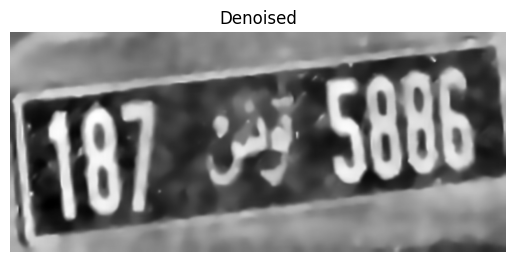

In [15]:
denoised = cv2.fastNlMeansDenoising(gray_clahe, h=30)

plt.imshow(denoised, cmap='gray')
plt.title("Denoised")
plt.axis('off')


(-0.5, 850.5, 376.5, -0.5)

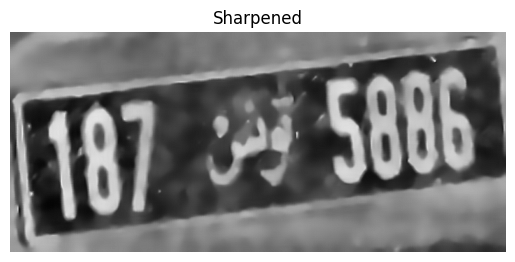

In [16]:
import numpy as np

kernel = np.array([[0,-1,0],
                   [-1,5,-1],
                   [0,-1,0]])

sharpen = cv2.filter2D(denoised, -1, kernel)

plt.imshow(sharpen, cmap='gray')
plt.title("Sharpened")
plt.axis('off')


(-0.5, 850.5, 376.5, -0.5)

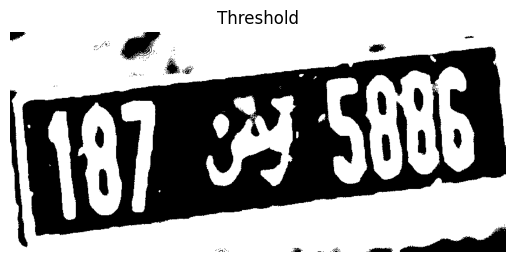

In [17]:
_, thresh = cv2.threshold(sharpen, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(thresh, cmap='gray')
plt.title("Threshold")
plt.axis('off')


In [ ]:
import easyocr
import cv2
import re


gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
reader = easyocr.Reader(['ar', 'en'], gpu=True)

result = reader.readtext(gray, detail=0)
print("Corrected OCR text:", result)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Corrected OCR text: ['&509 تبن 107']


In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = crop.copy()

h, w = img.shape[:2]

# ⚠️ Replace these with your real plate corners
pts_src = np.array([
    [5, 5],          # top-left
    [w-5, 10],       # top-right
    [w-10, h-5],     # bottom-right
    [10, h-10]       # bottom-left
], dtype=np.float32)


In [22]:
plate_width = 400
plate_height = 120

pts_dst = np.array([
    [0, 0],
    [plate_width, 0],
    [plate_width, plate_height],
    [0, plate_height]
], dtype=np.float32)


(-0.5, 399.5, 119.5, -0.5)

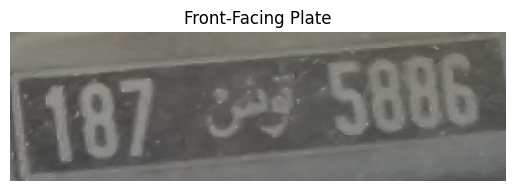

In [23]:
H = cv2.getPerspectiveTransform(pts_src, pts_dst)
warped = cv2.warpPerspective(img, H, (plate_width, plate_height))

plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title("Front-Facing Plate")
plt.axis('off')


(-0.5, 399.5, 119.5, -0.5)

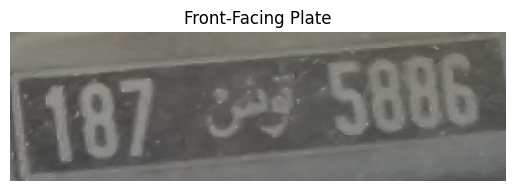

In [24]:
H = cv2.getPerspectiveTransform(pts_src, pts_dst)
warped = cv2.warpPerspective(img, H, (plate_width, plate_height))

plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title("Front-Facing Plate")
plt.axis('off')


In [30]:
import os
from ultralytics import YOLO

# On remonte d'un dossier (..) puis on entre dans 'models'
model_path = os.path.join("..", "models", "best1.pt")

if os.path.exists(model_path):
    model = YOLO(model_path)
    print(" Succès ! Le modèle est chargé.")
else:
    print(f" Toujours introuvable à : {os.path.abspath(model_path)}")
    print("Vérifiez que le dossier 'models' est bien dans 'SmartALPR_Project' et non dans 'modules'.")

 Succès ! Le modèle est chargé.


In [34]:
from paddleocr import PaddleOCR
import logging

# Désactiver les logs pour la clarté
logging.getLogger("ppocr").setLevel(logging.ERROR)

# Nouvelle syntaxe pour les versions récentes
ocr_engine = PaddleOCR(
    device='cpu',                   # Remplace use_gpu=False
    lang='en',                      # Utilisez 'ar' pour les plaques tunisiennes
    use_textline_orientation=True    # Remplace use_angle_cls=True
)

Fetching 6 files: 100%|██████████| 6/6 [00:20<00:00,  3.44s/it]
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Using official model (en_PP-OCRv5_mobile_rec), the model files will be automatically downloaded and saved in `C:\Users\HP GAMING\.paddlex\official_models\en_PP-OCRv5_mobile_rec`.
[2026-01-27 20:46:50,225] [    INFO] _client.py:1025 - HTTP Request: GET https://huggingface.co/api/models/PaddlePaddle/en_PP-OCRv5_mobile_rec/revision/main "HTTP/1.1 200 OK"
Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s][2026-01-27 20:46:50,438] [    INFO] _client.py:1025 - HTTP Request: HEAD https://huggingface.co/PaddlePaddle/en_PP-OCRv5_mobile_rec/resolve/267c36e24c331595590fe7bd72bde2436fd286f2/config.json "HTTP/1.1 307 Temporary Redirect"
[2026-01-27 20:46:50,553] [    INFO] _client.py:1025 - HTTP Request: HEAD https://huggingface.co/PaddlePaddle/en_PP-OCRv5_mobile_rec/resolve/267c36e24c331595590fe7bd72bde2436fd286f2/.gitattributes "HTTP/1.1 307 Temporary Redirect"
[2026-01-27 20:46:5

In [38]:
import os
import cv2
import logging
from paddleocr import PaddleOCR
from ultralytics import YOLO

# A. Désactiver l'optimisation MKLDNN qui cause le crash sur CPU Windows
os.environ['FLAGS_enable_mkldnn'] = '0'

# B. Configurer les logs
logging.getLogger("ppocr").setLevel(logging.ERROR)

# C. Initialisation avec des modèles "Mobile" (plus stables et rapides sur CPU)
# On force l'utilisation de la version v4 qui est la plus stable actuellement
ocr_engine = PaddleOCR(
    device='cpu',
    lang='en',
    use_textline_orientation=True,
    ocr_version='PP-OCRv4', 
    structure_version='PP-StructureV2'
)

model = YOLO("yolov8n.pt")
img = cv2.imread(r"D:\Downloads\SmartALPR_Project\merged_dataset\test\images\2.jpg")

results = model.predict(source=img, conf=0.25, device="cpu", verbose=False)

if len(results[0].boxes) > 0:
    box = results[0].boxes.xyxy[0].cpu().numpy().astype(int)
    
    # Sécurité : On s'assure que le crop n'est pas trop grand
    crop = img[box[1]:box[3], box[0]:box[2]]
    
    # Si le crop est malgré tout immense, on le redimensionne pour l'OCR
    if crop.shape[1] > 1000:
        crop = cv2.resize(crop, (640, int(640 * crop.shape[0] / crop.shape[1])))

    # D. Utiliser 'predict' au lieu de 'ocr' pour suivre la nouvelle API
    # Le résultat reste structuré de la même façon
    result = ocr_engine.predict(crop)

    if result and result[0]:
        for line in result[0]:
            print(f"💎 Matricule : {line[1][0].upper()}")
else:
    print("❌ Aucune plaque détectée.")

ValueError: Unknown argument: structure_version

In [25]:
import re
corrected_result = [
    " ".join(['تونس' if 'ت' in word else word for word in text.split()])
    for text in result
]

print("Corrected OCR text:", corrected_result)


Corrected OCR text: ['&509 تونس 107']
